In [1]:
all_event_wide_lists_withoutavg_1_8 <- readRDS("all_event_wide_lists_withoutavg_1_8.RDS")

In [2]:
library(dplyr)
library(tidyr)
library(stringr)
library(purrr)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
#data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]][1:5000, ]
data_list <- all_event_wide_lists_withoutavg_1_8[["SE"]][["Bombyx_mori"]]

In [4]:
########################################
## 1.  先挑出元信息列 + PSI列
########################################

In [5]:
meta_cols <- c("GeneID","geneSymbol","chr","strand",
               "exonStart_0base","exonEnd","upstreamES","upstreamEE","downstreamES","downstreamEE")

In [6]:
psi_cols <- setdiff(colnames(data_list), meta_cols)


In [7]:
data_long <- data_list %>%
  select(all_of(meta_cols), all_of(psi_cols)) %>%
  pivot_longer(
    cols      = all_of(psi_cols),         # 要从宽转长的列
    names_to  = "Stage_Tissue",           # 原本列名会存到这
    values_to = "PSI_string"              # 原本的PSI字符串
  )

In [9]:
print(data_long)

# A tibble: 44,873,543 × 12
   GeneID  geneSymbol chr   strand exonStart_0base exonEnd upstreamES upstreamEE
   <chr>   <chr>      <chr> <chr>            <dbl>   <dbl>      <dbl>      <dbl>
 1 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 2 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 3 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 4 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 5 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 6 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 7 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 8 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
 9 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682
10 LOC100… NA         chrN… +             10539898  1.05e7   10539531   10539682


In [10]:
data_long_parsed <- data_long %>%
  # 把 PSI_string 用逗号分隔拆开到多行
  separate_rows(PSI_string, sep = ",") %>%
  # 把字符转换为数值(过滤真正的NA或空字符)
  mutate(PSI_value = as.numeric(PSI_string)) %>%
  # 可能会有一些NA，去掉
  filter(!is.na(PSI_value)) %>%
  # 如果想对同一个GeneID & Stage_Tissue的重复值取平均：
  group_by(GeneID, Stage_Tissue) %>%
  summarise(PSI_value = mean(PSI_value), .groups="drop")

In [11]:
print(data_long_parsed)

# A tibble: 431,412 × 3
   GeneID Stage_Tissue                         PSI_value
   <chr>  <chr>                                    <dbl>
 1 +nsd-2 Adult__1_day__Fat_body                 0.962  
 2 +nsd-2 Adult__1_day__Thorax                   0.96   
 3 +nsd-2 Larva__0_day_of_3_instar__Whole_body   0.719  
 4 +nsd-2 Larva__0_day_of_5_instar__Digestive    0.007  
 5 +nsd-2 Larva__1_instar__Whole_body            0.512  
 6 +nsd-2 Larva__3-5_days__Digestive             0.011  
 7 +nsd-2 Larva__3_day_of_4_instar__Digestive    0.00583
 8 +nsd-2 Larva__3_day_of_5_instar__Digestive    0.676  
 9 +nsd-2 Larva__3_day_of_5_instar__Excretory    0.996  
10 +nsd-2 Larva__5_instar__Digestive             0.706  
# ℹ 431,402 more rows


In [12]:
data_long_parsed2 <- data_long_parsed %>%
  separate(
    col    = Stage_Tissue,
    into   = c("Stage","Stage-xifen", "Tissue"),
    sep    = "__",
    remove = FALSE  # 保留原列
  )


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = case_when(
      Stage == "Cell" ~ "Egg",
      TRUE                        ~ Stage
    )
  ) %>%
  mutate(
    Tissue = case_when(
      Tissue %in% c("Egg", "Pupa") ~ "Whole_body",  # Egg/Pupa -> Whole_body
      TRUE                        ~ Tissue          # 其他情况保持不变
    )
  )

In [13]:
stage_levels <- c( "Egg", "Larva", "Pupa", "Adult") 


data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Stage = factor(Stage, levels = stage_levels),  # 大时期排序
    Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-")  # 联合字段
  ) %>%
  arrange(Stage, `Stage-xifen`)  # 同一大时期内按细分时期排序

In [14]:
saveRDS(data_long_parsed2, file = "data_long_parsed2.RDS")

In [15]:
get_earliest_stage_cor_bootstrap <- function(df_grouped, n_boot = 1000, seed = 123) {
  set.seed(seed)
  
  #（a）检查数据是否为空
  df_valid <- df_grouped %>%
    filter(!is.na(Stage), !is.na(`Stage-xifen`))
  if (nrow(df_valid) == 0) {
    return(
      tibble(
        Stage      = NA,
        `Stage-xifen` = NA,
        Tissue     = unique(df_grouped$Tissue),
        cor_median = NA_real_,
        cor_lower  = NA_real_,
        cor_upper  = NA_real_,
        n_genes    = NA_integer_
      )
    )
  }
  
  #（b）按 {Stage, Stage-xifen} 找到最早的时期
  earliest_stage <- df_valid %>%
    arrange(Stage, `Stage-xifen`) %>%  # 先按大时期，再按细分时期排序
    slice(1) %>%
    select(Stage, `Stage-xifen`) %>%
    mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))  # 联合时期
  
  #（c）提取最早时期的 PSI 数据
  df_earliest <- df_valid %>%
    filter(Stage == earliest_stage$Stage[1] & `Stage-xifen` == earliest_stage$`Stage-xifen`[1]) %>%
    select(GeneID, PSI_earliest = PSI_value)
  
  #（d）将其他时期的数据与最早时期合并
  df_compare <- df_valid %>%
    filter(!(Stage == earliest_stage$Stage[1] & `Stage-xifen` == earliest_stage$`Stage-xifen`[1])) %>%
    left_join(df_earliest, by = "GeneID") %>%
    filter(!is.na(PSI_earliest))  # 去掉参考 PSI 为空的行
  
  #（e）如果没有其他时期可比较，则只返回最早时期
  if (nrow(df_compare) == 0) {
    return(
      tibble(
        Stage      = earliest_stage$Stage[1],
        `Stage-xifen` = earliest_stage$`Stage-xifen`[1],
        Tissue     = unique(df_grouped$Tissue),
        cor_median = 1,
        cor_lower  = 1,
        cor_upper  = 1,
        n_genes    = nrow(df_earliest)
      )
    )
  }
  
  #（f）对每个细分时期做 bootstrap 相关
  cor_boot <- df_compare %>%
    group_by(Stage, `Stage-xifen`) %>%
    group_modify(~ {
      df_stage <- .x
      cor_vec <- numeric(n_boot)
      for (i in seq_len(n_boot)) {
        idx <- sample(seq_len(nrow(df_stage)), size = nrow(df_stage), replace = TRUE)
        sample_df <- df_stage[idx, ]
        if (length(unique(sample_df$PSI_value)) < 2 || length(unique(sample_df$PSI_earliest)) < 2) {
          cor_vec[i] <- NA_real_
        } else {
          cor_vec[i] <- cor(sample_df$PSI_value, sample_df$PSI_earliest, use = "pairwise.complete.obs")
        }
      }
      tibble(
        Tissue      = unique(df_stage$Tissue),
        cor_median  = median(cor_vec, na.rm = TRUE),
        cor_lower   = quantile(cor_vec, probs = 0.025, na.rm = TRUE),
        cor_upper   = quantile(cor_vec, probs = 0.975, na.rm = TRUE),
        n_genes     = nrow(df_stage)
      )
    })
  
  #（g）把最早时期也加回来
  cor_boot_earliest <- tibble(
    Stage      = earliest_stage$Stage[1],
    `Stage-xifen` = earliest_stage$`Stage-xifen`[1],
    Tissue     = unique(df_compare$Tissue),
    cor_median = 1,
    cor_lower  = 1,
    cor_upper  = 1,
    n_genes    = nrow(df_earliest)
  )
  
  result <- bind_rows(cor_boot_earliest, cor_boot) %>%
    arrange(Stage, `Stage-xifen`)
  return(result)
}

In [16]:
cor_all <- data_long_parsed2 %>%
  group_by(Tissue) %>%
  nest() %>%
  mutate(
    cor_table = map(
      data,
      ~ get_earliest_stage_cor_bootstrap(.x, n_boot = 1000, seed = 123)
    )
  ) %>%
  select(-data) %>%
  unnest(cols = cor_table)

Warning message:
“There were 138 warnings in `mutate()`.
The first warning was:
ℹ In argument: `cor_table = map(...)`.
ℹ In group 1: `Tissue = "Developmental_tissue"`.
Caused by warning:
! Unknown or uninitialised column: `Tissue`.
ℹ Run `dplyr::last_dplyr_warnings()` to see the 137 remaining warnings.”


In [17]:
# 先数一下每个Tissue的阶段有多少个
tissue_stage_count <- cor_all %>%
  group_by(Tissue) %>%
  summarise(n_stage = n_distinct(Stage))

# 找到至少有3个不同Stage的组织
valid_tissue <- tissue_stage_count %>%
  filter(n_stage >= 2) %>%
  pull(Tissue)

# 筛选 cor_all
cor_all <- cor_all %>%
  filter(Tissue %in% valid_tissue)

In [18]:
cor_all <- cor_all %>%
  mutate(Combined_Stage = paste(Stage, `Stage-xifen`, sep = "-"))

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = unique(data_long_parsed2$Combined_Stage)  # 确保顺序一致
    )
  )

In [19]:
custom_order <- c(
  "Egg-0_days", "Egg-20-22_hours", "Egg-24_hours", "Egg-1_day", "Egg-2_days",  "Egg-36_hours", "Egg-3_days", "Egg-72_hours", "Egg-120_hours","Egg-168_hours",  "Egg-192_hours", "Egg-216_hours", 
  "Larva-0_hours", "Larva-1_day_of_1_instar", "Larva-48_hours", "Larva-96_hours" , "Larva-1_instar", "Larva-2_instar", "Larva-0_day_of_3_instar", "Larva-24_hours_of_4_instar", "Larva-1_day_of_4_instar", "Larva-2_day_of_4_instar", "Larva-3_day_of_4_instar", "Larva-4_day_of_4_instar", "Larva-4_instar" , "Larva-10_day_of_4_instar", "Larva-11_day_of_4_instar", "Larva-12_day_of_4_instar", "Larva-0_day_of_5_instar", "Larva-1_day_of_5_instar", "Larva-2_day_of_5_instar", "Larva-3_day_of_5_instar", "Larva-4_day_of_5_instar", "Larva-5_instar","Larva-6_day_of_5_instar", "Larva-7_day_of_5_instar", "Larva-8_day_of_5_instar" , "Larva-9_day_of_5_instar", "Larva-10_day_of_5_instar", "Larva-12_day_of_5_instar", "Larva-13_day_of_5_instar", "Larva-14_day_of_5_instar", "Larva-15_day_of_5_instar", "Larva-wandering_stage", "Larva-36h_wandering_stage","Larva-52h_wandering_stage", 
  "Pupa-stage_5", 
  "Adult-0h","Adult-1_day", "Adult-2_days", "Adult-4_days","Adult-5_days"
)
# 从数据中过滤掉不需要的时期
data_long_parsed2 <- data_long_parsed2 %>%
  filter(Combined_Stage %in% custom_order)

cor_all <- cor_all %>%
  filter(Combined_Stage %in% custom_order)
data_long_parsed2 <- data_long_parsed2 %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 手动指定顺序
    )
  )

cor_all <- cor_all %>%
  mutate(
    Combined_Stage = factor(
      Combined_Stage,
      levels = custom_order  # 保持顺序一致
    )
  )

In [20]:
# 设置置信区间范围阈值
threshold <- 0.5

# 剔除置信区间范围过大的点
cor_all_filtered <- cor_all %>%
  filter((cor_upper - cor_lower) <= threshold | is.na(cor_upper - cor_lower))

library(zoo)

# 对每个 Tissue 分组，进行插值平滑处理
cor_all_smoothed <- cor_all_filtered %>%
  group_by(Tissue) %>%
  mutate(
    cor_median_smooth = na.approx(cor_median, na.rm = FALSE),  # 平滑中位数
    cor_lower_smooth = na.approx(cor_lower, na.rm = FALSE),    # 平滑下界
    cor_upper_smooth = na.approx(cor_upper, na.rm = FALSE)     # 平滑上界
  ) %>%
  ungroup()


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




In [21]:
p <- # 用平滑后的数据进行绘图
  ggplot(cor_all_smoothed, aes(x = Combined_Stage, y = cor_median_smooth, group = Tissue, color = Tissue)) +
  geom_ribbon(aes(ymin = cor_lower_smooth, ymax = cor_upper_smooth, fill = Tissue), alpha = 0.2, color = NA) +
  geom_line() +
  geom_point() +
  theme_bw(base_size = 14) +
  labs(
    title = "PSI correlation with filtered and smoothed confidence intervals",
    x = "Stage",
    y = "Pearson correlation (median ± 95% CI)"
  ) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )



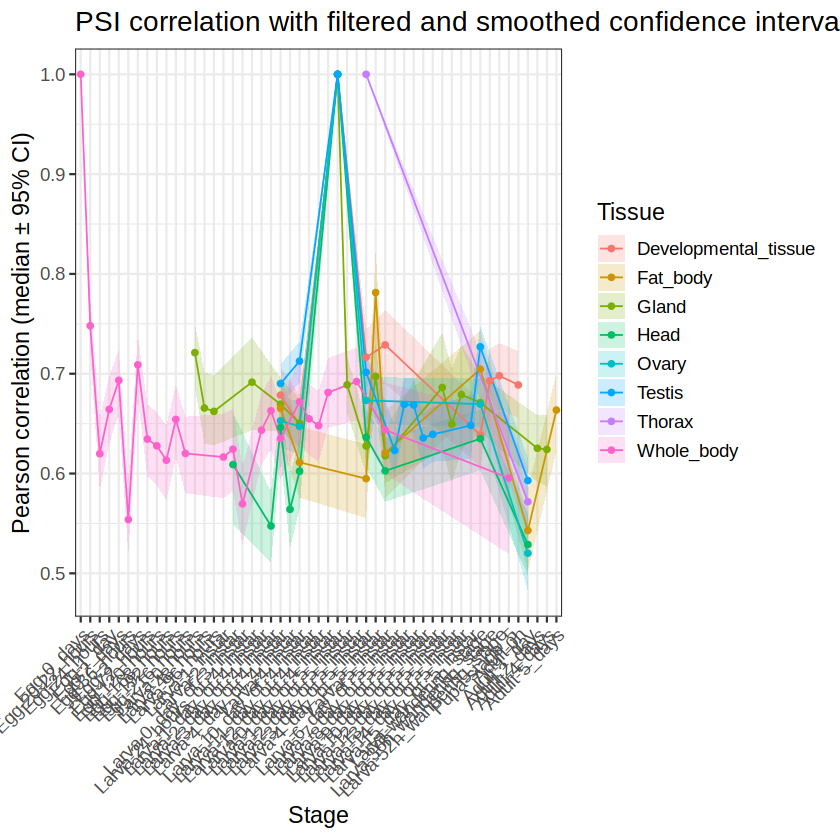

In [23]:
print(p)

In [31]:
ggsave("correlation_plot.png", p, width = 10, height = 6, dpi = 300)
